In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/2024 Term 8/50.021 AI/project/RL
!pwd
!ls

/content/drive/MyDrive/2024 Term 8/50.021 AI/project/RL
/content/drive/MyDrive/2024 Term 8/50.021 AI/project/RL
11x11_generalized_cnn_5000  DQN_generalized_cnn_11x11.ipynb  loss.py	     requirements.txt
9x9_generalized_cnn_5000    environment.py		     maze_11x11.pdf  training.py
9x9_generalized_fcn_5000    evaluation.py		     maze_9x9.pdf    utils.py
agent.py		    file_structure.txt		     models
data			    loss.pdf			     __pycache__


In [4]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections
from torch.utils.data import Dataset
from datasets import Dataset, Features, Array2D, Value, load_dataset, load_from_disk

from environment import MazeEnvironment
from agent import Agent

from models.experience import ExperienceReplay
from models.fcn import fc_nn
from models.cnn import conv_nn
from training import train
from evaluation import evaluation
from utils import *

from sklearn.metrics import f1_score, accuracy_score
from torchsummary import summary

from matplotlib.colors import ListedColormap
from statistics import mean

from tqdm.notebook import tqdm
import json
import ast

%load_ext autoreload
%autoreload 2

In [5]:
class config:
    maze_size = "15x15"
    buffer_capacity = 10000
    buffer_start_size = 1000
    network = "cnn"
    num_epochs = 5000
    cutoff = 3000
    device = 'cuda'
    batch_size = 32
    gamma = 0.9
    generalized = True
    folder = f'{maze_size}_{"generalized" if generalized else "simple"}_{network}_{num_epochs}'
    save_filename = f'{folder}/{maze_size}_{"generalized" if generalized else "simple"}_{network}_{num_epochs}.torch'

In [6]:
class paths:
    train_9x9 = "./data/train/9x9_train.hf"
    train_11x11 = "./data/train/11x11_train.hf"
    train_15x15 = "./data/train/15x15_train.hf"
    train_21x21 = "./data/train/21x21_train.hf"
    test_9x9 = "./data/test/9x9/borderless_9x9_test.hf"
    test_11x11 = "./data/test/11x11/borderless_11x11_test.hf"
    test_15x15 = "./data/test/15x15/borderless_15x15_test.hf"
    test_21x21 = "./data/test/21x21/borderless_21x21_test.hf"

In [7]:
print(config.save_filename)
print(config.folder)

15x15_generalized_cnn_5000/15x15_generalized_cnn_5000.torch
15x15_generalized_cnn_5000


In [8]:
!mkdir 15x15_generalized_cnn_5000

# Load training data

(30000, 2)
---------------------
{'maze': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]]), 'groundtruth': tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
        [1

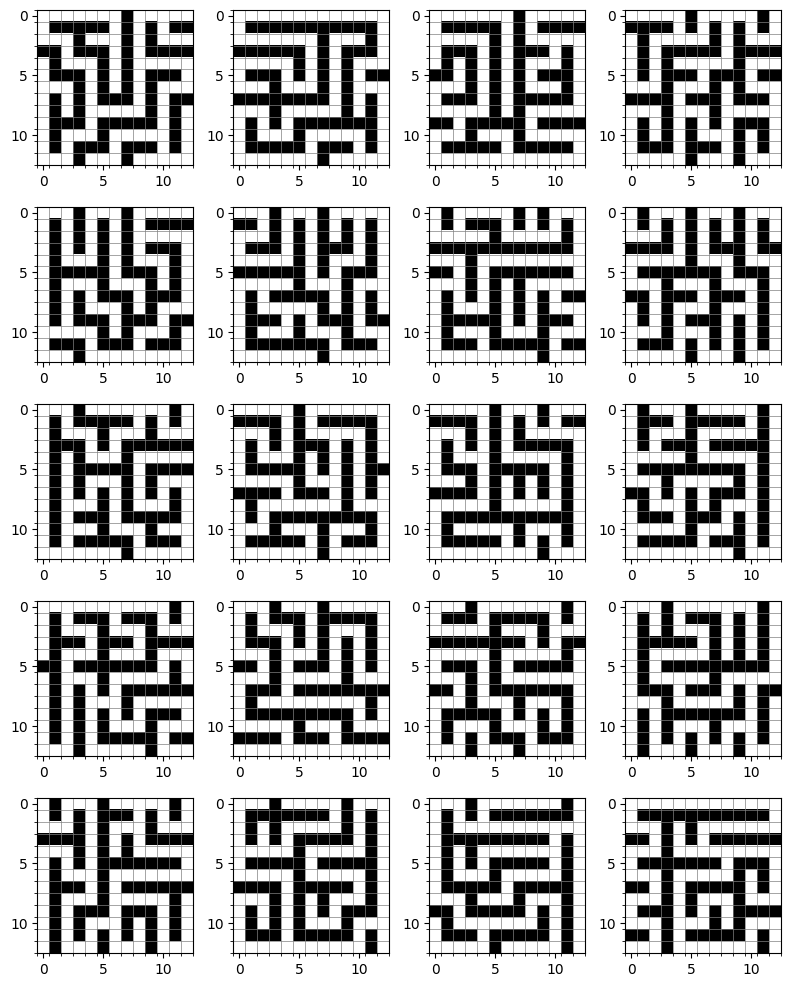

In [9]:
training_data = load_data(paths.train_15x15)
visualize_mazes(training_data, n = 20)

# Visualize Maze Environment

Visualization of maze:


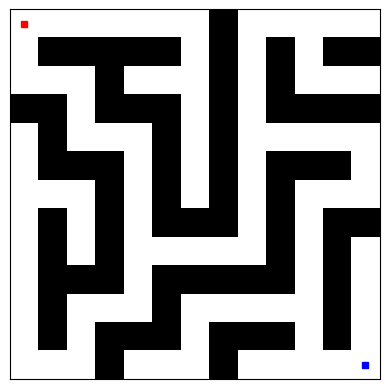

In [10]:
maze = training_data[0]['maze'].numpy()
initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]
maze_env = MazeEnvironment(maze, initial_position, goal)

print("Visualization of maze:")
maze_env.draw(f'maze_{config.maze_size}.pdf')

In [12]:
memory_buffer = ExperienceReplay(config.buffer_capacity)
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

if config.network == "cnn":
    net = conv_nn(maze.shape[0], maze.shape[1], 4)
else:
    net = fc_nn(maze.size, maze.size, maze.size, 4)

net.to(config.device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

summary(net, (13,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 11, 11]             160
              ReLU-2           [-1, 16, 11, 11]               0
            Conv2d-3             [-1, 32, 9, 9]           4,640
              ReLU-4             [-1, 32, 9, 9]               0
            Linear-5                  [-1, 338]         876,434
              ReLU-6                  [-1, 338]               0
            Linear-7                   [-1, 84]          28,476
              ReLU-8                   [-1, 84]               0
            Linear-9                    [-1, 4]             340
Total params: 910,050
Trainable params: 910,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 3.47
Estimated Total Size (MB): 3.55
-------------------------------------------

In [13]:
epsilon = np.exp(-np.arange(config.num_epochs)/(config.cutoff))
epsilon[epsilon > epsilon[100*int(config.num_epochs/config.cutoff)]] = epsilon[100*int(config.num_epochs/config.cutoff)]

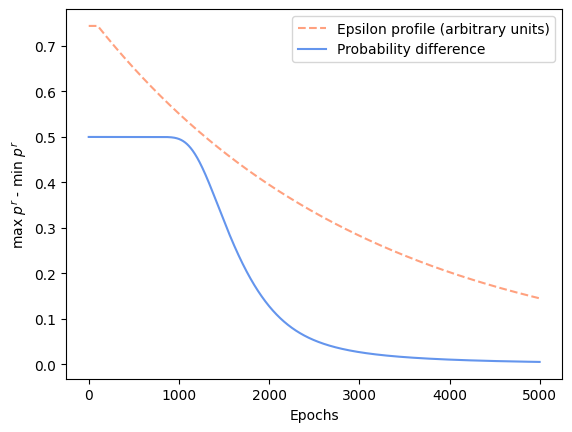

In [14]:
# Visualize epsilon
mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig(f'{config.folder}/reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Training

In [15]:
loss_log, maze_change_log, move_log, result_log = train(agent, net, optimizer, epsilon, training_data, config)

Epoch 4999 (number of moves 181)
Game won
[####################################################################################################]
	 Average loss: 0.11835
	 Best average loss of the last 50 epochs: 0.09045, achieved at epoch 4334


In [16]:
torch.save(net.state_dict(), config.save_filename)

In [17]:
print("=======================")
print(f'Loss logs: {loss_log}')
print(f'Log for which epoch where maz is changed: {maze_change_log}')
print(f'Num of moves at each epoch: {move_log}')
print(f'Number of times maze is changed: {len(maze_change_log)}')
print("------------------------")

print(f'Win/loss result at each epoch: {result_log}')
won_log = [1 if x == "won" else 0 for x in result_log]
print("# win:", sum(won_log))
print("# loss:", len(won_log)-sum(won_log))
print("=======================")

Loss logs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72.52823430299759, 62.08777393400669, 2.12128908932209, 59.2024100869894, 0.30705706775188446, 0.3329112231731415, 7.6380079463124275, 42.38024166226387, 1.332065612077713, 0.4743935838341713, 0.42489977180957794, 3.0950312316417694, 2.8557271286845207, 9.833064705133438, 0.2637696787714958, 0.5019326135516167, 2.932907536625862, 3.7433533743023872, 39.5939433015883, 0.16438599303364754, 33.3527782317251, 0.206607386469841, 0.20845749229192734, 17.20162834227085, 0.0706299003213644, 0.13941556215286255, 0.1750340573489666, 0.2576022371649742, 26.523952800780535, 11.99980965256691, 0.24594807624816895, 0.27043534629046917, 0.2783277854323387, 26.782278588041663, 1.0095956586301327, 0.12016652524471283, 0.4300926923751831, 0.08795611932873726, 0.3757956773042679, 0.995638083666563, 6.571616427972913, 0.07817143946886063, 0.047596726566553116, 0.1347000673413276

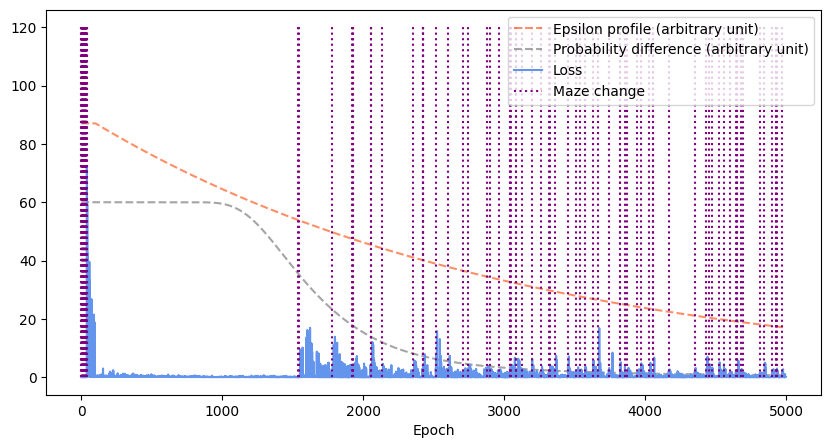

In [18]:
# Visualize loss
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
ax.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
ax.plot(loss_log, label = 'Loss', color = 'cornflowerblue')

# multiple lines all full height
ax.vlines(x = maze_change_log, ymin = 0, ymax = 120,
           colors = 'purple',
           linestyles = "dotted", label = "Maze change")


ax.set_xlabel('Epoch')
ax.set_ylabel('')
ax.legend()
fig.savefig('loss.pdf', dpi = 300, bbox_inches='tight')
plt.show()

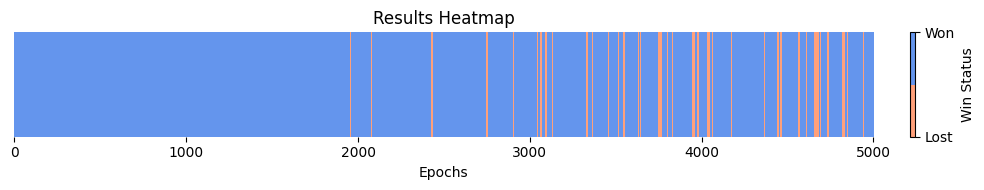

In [19]:
# Win loss plot
plt.rcParams["figure.figsize"] = (10, 2)  # Setting figure size

# Creating a 2D view of won_log by adding a new axis
won_log_2d = np.array(won_log)[np.newaxis, :]

# Plotting won_log as a heatmap
fig, ax = plt.subplots()
extent = [0, len(won_log), 0, 1]  # Define the extent of the axes [xstart, xend, ystart, yend]
cmap = ListedColormap(['#FFA07A', '#6495ED'])  # Bright red and bright blue

cax = ax.imshow(won_log_2d, aspect="auto", cmap=cmap, extent=extent)
ax.set_yticks([])  # No need for y ticks in a 1D heatmap
ax.set_xlabel("Epochs")
ax.set_title("Results Heatmap")

# Removing the box (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Adding a legend
# Create a colorbar as a legend, since the data is continuous for color mapping
colorbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
colorbar.set_label('Win Status')
colorbar.set_ticks([0, 1])  # Set ticks to match binary data
colorbar.set_ticklabels(['Lost', 'Won'])  # Set custom labels

plt.tight_layout()
plt.show()


# Testing

In [20]:
class test_config:
    max_step = 31
    test_directions = {"RIGHT": '→',
                   "LEFT": '←',
                   "DOWN": '↓',
                   "UP": '↑'}

(10000, 3)
---------------------
{'maze': tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]), 'steps': tensor(25), 'solution': '{"(1, 1)": "RIGHT", "(1, 2)": "RIGHT", "(1, 3)": "DOWN", "(2, 3)": "DOWN", "(3, 3)": "RIGHT", "(3, 4)": "RIGHT", "(3, 5)": "DOWN", "(4, 5)": "DOWN", "(5, 5)": "RIGHT", "(5, 6)": "RIGHT", "(5, 7)": "RIGHT", "(5, 8)": "RIGHT", "(5, 9)": "RIGHT", "(5, 10)": "RIGHT", "(5, 11)": "DOWN", "(

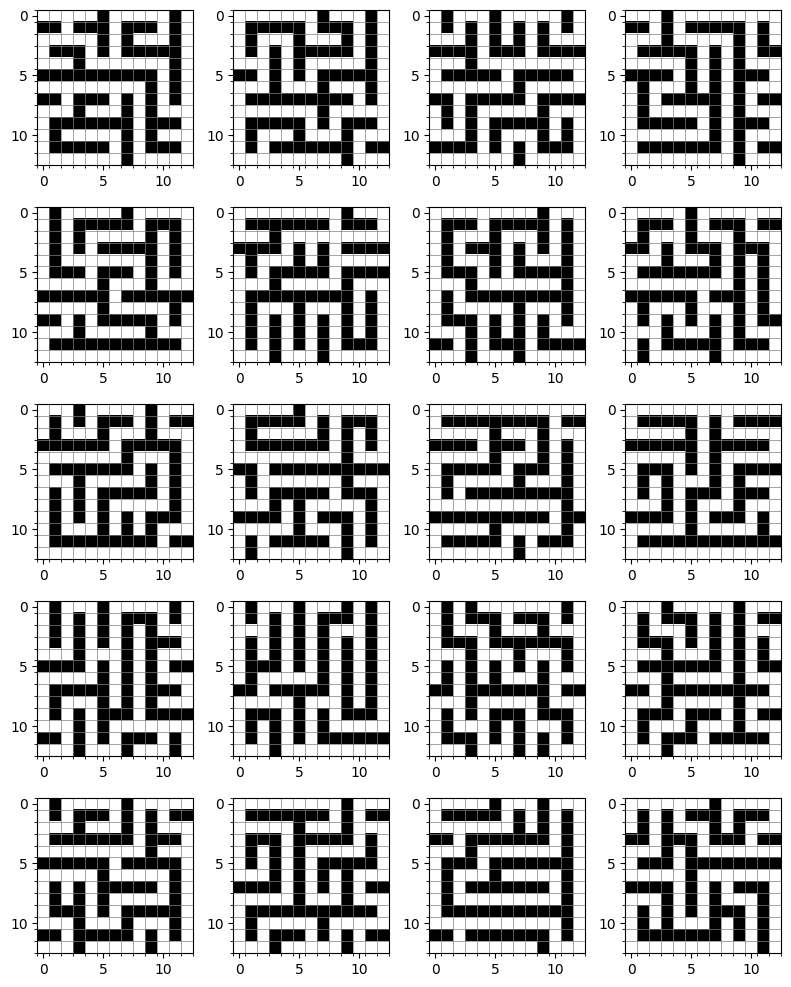

In [21]:
test_data = load_data(paths.test_15x15)
visualize_mazes(test_data)

In [22]:
overall_accuracy, overall_f1, overall_num_moves_goal, overall_solved_maze = evaluation(test_data, net, memory_buffer, test_config)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
print(f'List of accuracies: {overall_accuracy}')
print(f'List of f1: {overall_f1}')
print(f'Number of moves taken to solve each maze: {overall_num_moves_goal}')
print(f'Resulst for each maze: {overall_solved_maze}')

List of accuracies: [0.3333333333333333, 0.4166666666666667, 0.375, 0.3333333333333333, 0.1875, 0.26785714285714285, 0.25, 0.34375, 0.38636363636363635, 0.08333333333333333, 0.19444444444444445, 0.19444444444444445, 0.3333333333333333, 0.34375, 0.39285714285714285, 0.425, 0.1875, 0.45, 0.32142857142857145, 0.3333333333333333, 0.39285714285714285, 0.25, 0.275, 0.29545454545454547, 0.3181818181818182, 0.15625, 0.5, 0.2222222222222222, 0.2916666666666667, 0.10714285714285714, 0.34615384615384615, 0.28125, 0.25, 0.25, 0.15625, 0.19444444444444445, 0.19444444444444445, 0.26666666666666666, 0.25, 0.25, 0.375, 0.22727272727272727, 0.3333333333333333, 0.25, 0.475, 0.32142857142857145, 0.2857142857142857, 0.36363636363636365, 0.4722222222222222, 0.14285714285714285, 0.45, 0.1875, 0.3055555555555556, 0.3125, 0.3076923076923077, 0.2222222222222222, 0.36538461538461536, 0.26785714285714285, 0.39285714285714285, 0.45, 0.20454545454545456, 0.4166666666666667, 0.18181818181818182, 0.3382352941176471,

In [24]:
print(f'Mazes unsolved: {len(overall_solved_maze)}')
print(f'Mazes solved: {sum(overall_solved_maze)}')

Mazes unsolved: 10000
Mazes solved: 0


In [25]:
final_acc = mean(overall_accuracy)
final_f1 = mean(overall_f1)
print(f'Accuracy: {final_acc}')
print(f'F1: {final_f1}')

Accuracy: 0.27739471735469123
F1: 0.19103091973125066


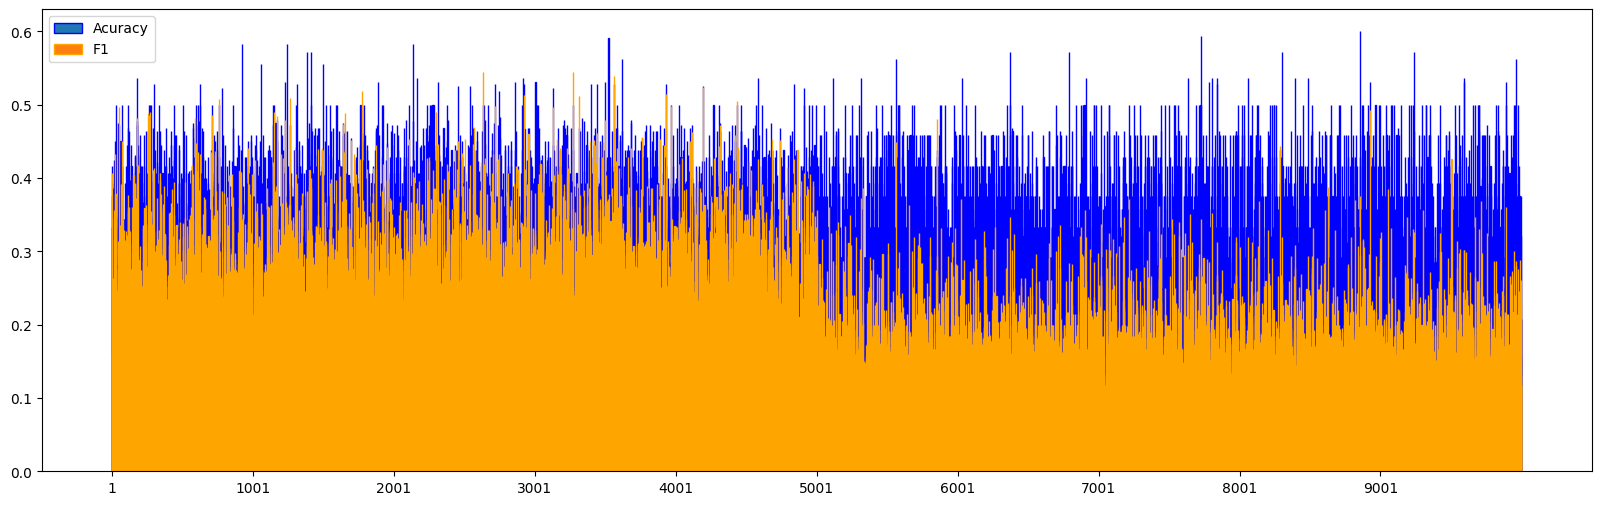

In [26]:
# Data
group1_values = overall_accuracy
group2_values = overall_f1
categories = list(range(1, len(group1_values) + 1))

# Set the width of the bars
barWidth = 0.3

plt.figure(figsize=(20, 6))  # 10 inches in width and 6 inches in height

# Set position of bar on X axis
r1 = np.arange(len(group1_values))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, group1_values, width=barWidth, edgecolor='blue', label='Group 1')
plt.bar(r2, group2_values, width=barWidth, edgecolor='orange', label='Group 2')

# Adjust range to match the number of categories
plt.xticks([r + barWidth/2 for r in range(len(categories))], categories)

# Label only certain intervals on the x-axis to avoid clutter
tick_positions = [r + barWidth/2 for r in range(len(categories)) if r % 1000 == 0]
tick_labels = [categories[i] for i in range(len(categories)) if i % 1000 == 0]

plt.xticks(tick_positions, tick_labels)

# Create legend & Show graphic
plt.legend(labels = ['Acuracy', 'F1'])
plt.show()


In [ ]:
# best_net = copy.deepcopy(net)
net.load_state_dict(torch.load(config.save_filename))